In [91]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/erik/Code/Skola/ID2223/mlfs-book
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [92]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [93]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON_A").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 14:03:48,417 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 14:03:48,420 INFO: Initializing external client
2025-11-18 14:03:48,421 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 14:03:49,998 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279161


In [94]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality_a',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_a',
    version=1,
)

# Get all streets from the feature group
all_urls_df = air_quality_fg.select(['url']).read()
urls = all_urls_df['url'].unique().tolist()
print(f"Found urls: {urls}")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 
Found urls: ['https://api.waqi.info/feed/A191545', 'https://api.waqi.info/feed/A474136', 'https://api.waqi.info/feed/A469291', 'https://api.waqi.info/feed/A66394']


--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 
Training model for street: Steyrerweg
2025-11-18 14:03:57,398 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_a` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.08s) 
Number of records for url https://api.waqi.info/feed/A191545: 1746
a191545
Creating feature view for code: a191545 Steyrerweg
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279161/fs/1273929/fv/air_quality_fv_a191545/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 
MSE: 5.685561
R squared: 0.5326255202221282


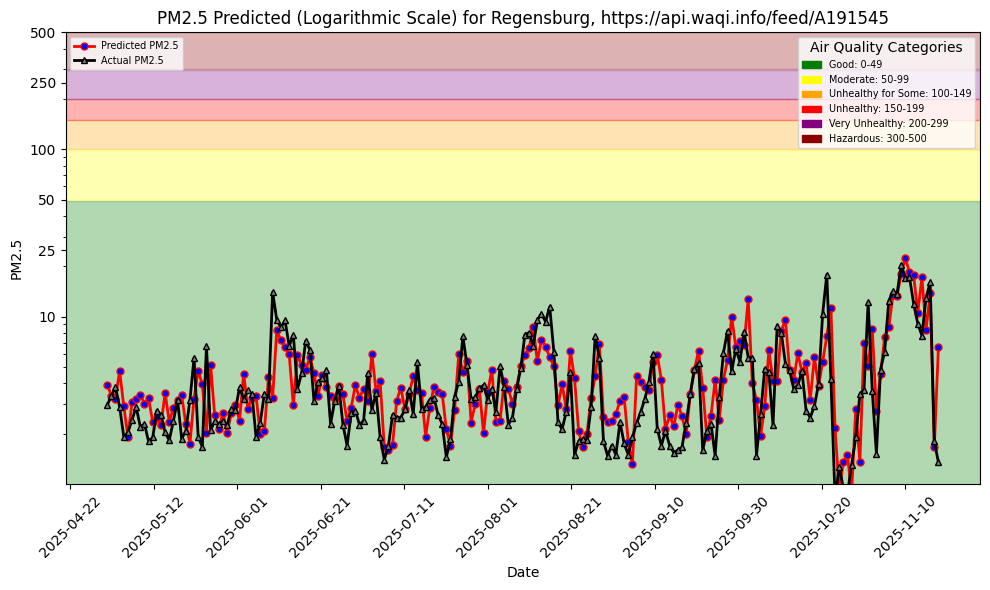

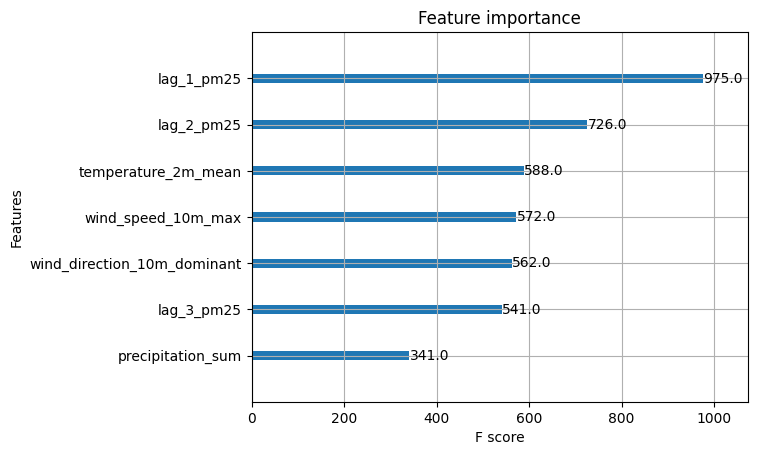

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a191545/model.json: 0…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a191545/images/a19154…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a191545/images/a19154…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/model_schema.json: 0.000%|          | 0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279161/models/air_quality_xgboost_model_a191545/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.88s) 
Training model for street: Pfeilstraße
2025-11-18 14:04:29,612 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_a` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 
Number of records for url https://api.waqi.info/feed/A474136: 591
a474136
Creating feature view for code: a474136 Pfeilstraße
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279161/fs/1273929/fv/air_quality_fv_a474136/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 
MSE: 3.6821299
R squared: 0.589685359196321


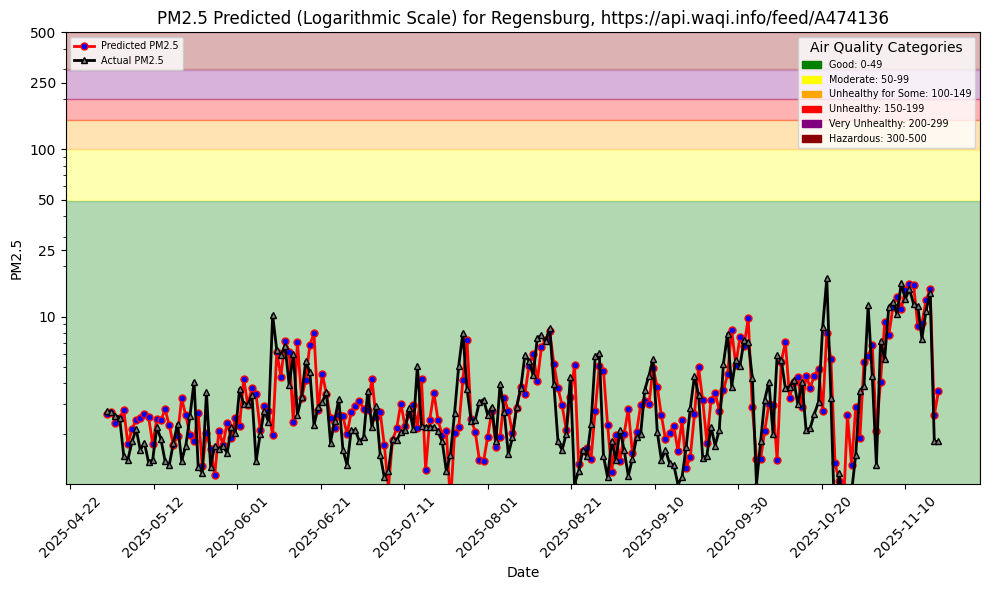

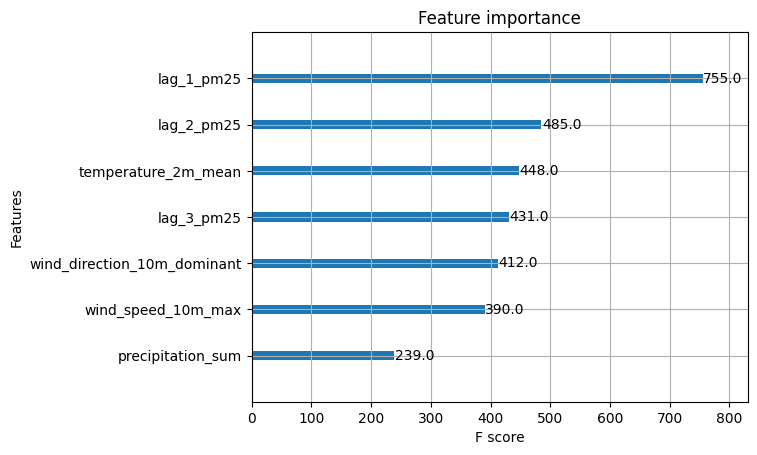

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a474136/model.json: 0…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a474136/images/a47413…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a474136/images/a47413…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/model_schema.json: 0.000%|          | 0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279161/models/air_quality_xgboost_model_a474136/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 
Training model for street: Hafnersteig
2025-11-18 14:05:01,050 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_a` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 
Number of records for url https://api.waqi.info/feed/A469291: 612
a469291
Creating feature view for code: a469291 Hafnersteig
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279161/fs/1273929/fv/air_quality_fv_a469291/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 
MSE: 0.96015793
R squared: 0.025623869092167295


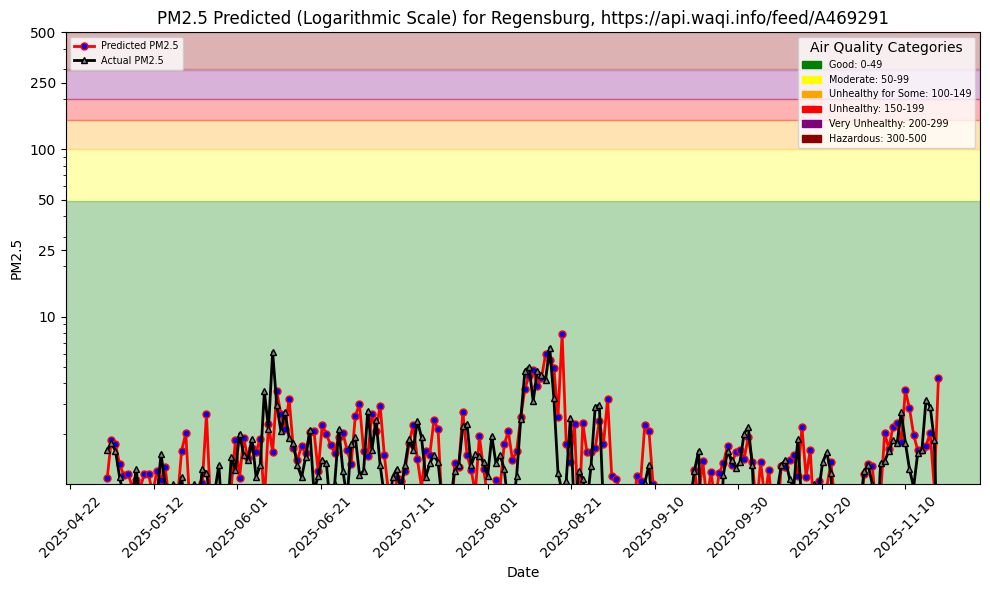

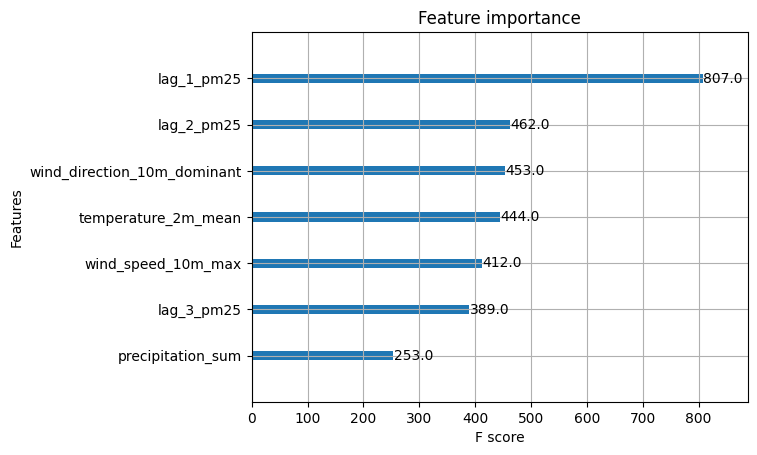

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a469291/model.json: 0…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a469291/images/a46929…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a469291/images/a46929…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/model_schema.json: 0.000%|          | 0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279161/models/air_quality_xgboost_model_a469291/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 
Training model for street: Fichtelgebirgstraße
2025-11-18 14:05:33,657 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_a` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 
Number of records for url https://api.waqi.info/feed/A66394: 2119
a66394
Creating feature view for code: a66394 Fichtelgebirgstraße
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279161/fs/1273929/fv/air_quality_fv_a66394/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 
MSE: 2.670557
R squared: -0.4631068114795356


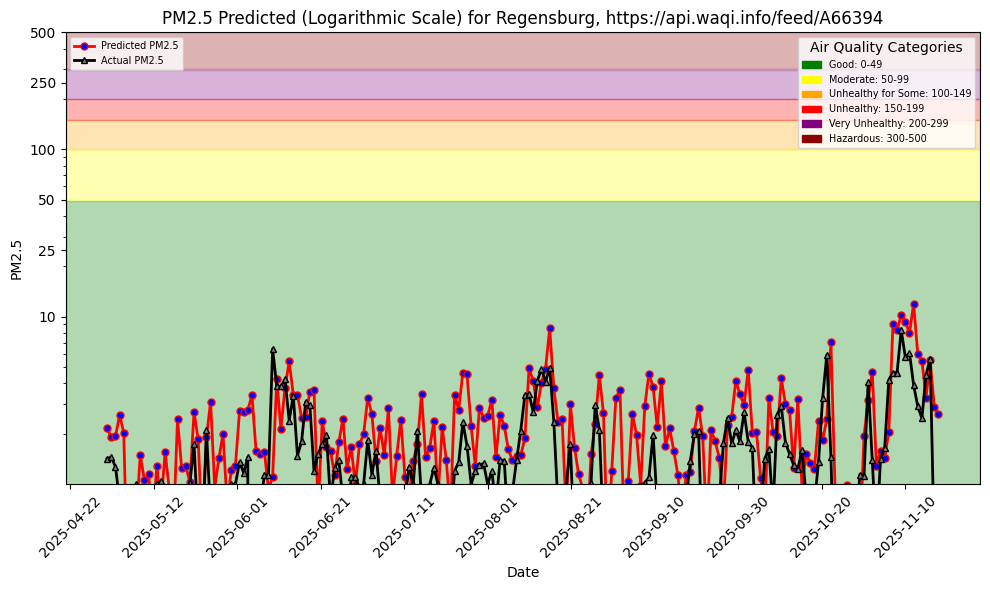

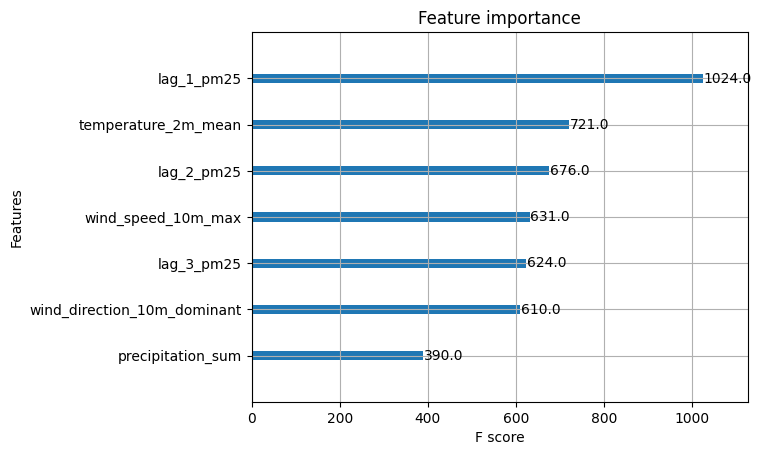

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a66394/model.json: 0.…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a66394/images/a66394/…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/air_quality_model_a66394/images/a66394/…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/notebooks/airquality/model_schema.json: 0.000%|          | 0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279161/models/air_quality_xgboost_model_a66394/1


In [95]:
# Select features for training data.
for url in urls:
    code = url.split("/")[-1].lower()
    street = air_quality_fg.filter(air_quality_fg.url == url).read()['street'].iloc[0]

    print(f"Training model for street: {street}")
    selected_features = air_quality_fg.select(['pm25',"lag_1_pm25","lag_2_pm25","lag_3_pm25", 'date']).filter(air_quality_fg.url == url).join(weather_fg.select_features(), on=['city'])
    print(f"Number of records for url {url}: {selected_features.read().shape[0]}")

    print(code)

    fv_name = f"air_quality_fv_{code}"

  
    print(f"Creating feature view for code: {code} {street}")
    feature_view = fs.get_or_create_feature_view(
        name=fv_name,
        description="weather features with air quality as the target",
        version=1,
        labels=['pm25'],
        query=selected_features,
    )
    start_date_test_data = "2025-05-01"
    # Convert string to datetime object
    test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")
    X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
    )
    X_features = X_train.drop(columns=['date'])
    X_test_features = X_test.drop(columns=['date'])
    y_train

    # Creating an instance of the XGBoost Regressor
    xgb_regressor = XGBRegressor()

    # Fitting the XGBoost Regressor to the training data
    xgb_regressor.fit(X_features, y_train)

    # Predicting target values on the test set
    y_pred = xgb_regressor.predict(X_test_features)

    # Calculating Mean Squared Error (MSE) using sklearn
    mse = mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)

    # Calculating R squared using sklearn
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)

    df = y_test
    df['predicted_pm25'] = y_pred

    df['date'] = X_test['date']
    df = df.sort_values(by=['date'])
    df.head(5)

    # Creating a directory for the model artifacts if it doesn't exist
    model_dir = f"air_quality_model_{code}"
    # create model_dir and nested images dir if needed
    images_dir = os.path.join(model_dir, "images", code)
    os.makedirs(images_dir, exist_ok=True)

    file_path = os.path.join(images_dir, "pm25_hindcast.png")
    # don't overwrite the `plt` module — just call the util plotting function
    util.plot_air_quality_forecast(city, url, df, file_path, hindcast=True)
    plt.show()

    # Plotting feature importances using the plot_importance function from XGBoost
    plot_importance(xgb_regressor)
    feature_importance_path = os.path.join(images_dir, "feature_importance.png")
    plt.savefig(feature_importance_path)
    plt.show()

    xgb_regressor.save_model(model_dir + "/model.json")

    res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

    mr = project.get_model_registry()

    # Creating a Python model in the model registry named 'air_quality_xgboost_model'

    aq_model = mr.python.create_model(
        name=f"air_quality_xgboost_model_{code}",
        metrics= res_dict,
        feature_view=feature_view,
        description="Air Quality (PM2.5) predictor",
    )

    # Saving the model artifacts to the 'air_quality_model' directory in the model registry
    aq_model.save(model_dir)